In [103]:
import albumentations as A 
import numpy as np 
import matplotlib.pyplot as plt 
from copy import deepcopy 

import sys 
sys.path.append('../utils/')
from random_noise import add_noise

| Augmentation | Applicable To |
|---|---|
| Polarity Reversal | Prestack , Post stack | 
| Random Trace Dropout | Prestack , Post stack | 
| Random High Noise traces | Prestack , Post stack |
| Random Amplitude Attenuation | Pre stack, Post stack |
| Trace Shuffle | Prestack, Post stack |
| Random Amplitude Shift | Prestack , Post stack | 
|Rotate | Post stack |

In [104]:
# dataset path 
dataset_path = '../data/faciesmark/train/train_seismic.npy'
patchsize = 128
stride = 128
info_path = '../data/faciesmark/train_patches_32_32_2d.csv'
mode = '2d'

dataset = np.load(dataset_path)

random_xline_start  = np.random.randint(0, 901 - patchsize)
random_twt_start = np.random.randint(0,255 - patchsize)
patch_clean = dataset[0, random_xline_start : random_xline_start + patchsize , random_twt_start : random_twt_start + patchsize].T
patch_clean.shape

patch_noisy  = add_noise(patch_clean, noise_factor=0.1)

patch_clean_original = deepcopy(patch_clean)
patch_noisy_original = deepcopy(patch_noisy)


In [105]:
def patch_stats(patch) : 
    return f'mean : {np.mean(patch)} , std : {np.std(patch)} , min : {np.min(patch)} , max : {np.max(patch)}'

In [106]:
def visualize(patch, patch_aug) : # patch = [clean, noisy] , patch_aug = [clean_aug, noisy_aug]
    kwargs = dict(cmap='seismic', vmin = -1, vmax = 1, aspect='auto')
    fig, ax = plt.subplots(ncols=4, figsize=(4 * 4,4))
    ax[0].imshow(patch[0], **kwargs)
    ax[0].set_title('Clean Original')
    ax[1].imshow(patch_aug[0], **kwargs)
    ax[1].set_title('Clean Augmented')
    ax[2].imshow(patch[1], **kwargs)
    ax[2].set_title('Noisy Original')
    ax[3].imshow(patch_aug[1], **kwargs)
    ax[3].set_title('Noisy Augmented')
    print('clean stats'  , patch_stats(patch[0]), patch_stats(patch[1]))
    print('noisy stats'  , patch_stats(patch_aug[0]), patch_stats(patch_aug[1]))
    plt.show()

An augmentation applied to clean image should also be applied to noisy image. 
Since, some of the augmentations are random in nature, the noisy image augmentation is different from clean. Hence, instead of applying same augmentation once to each, we could pass clean, noisy as a tuple and return clean_aug, noisy_aug as a tuple. 

With respect to Albumentations , both are passed into 'image' type

## Polarity Reversal

clean stats mean : 0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0
noisy stats mean : -0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : -0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0


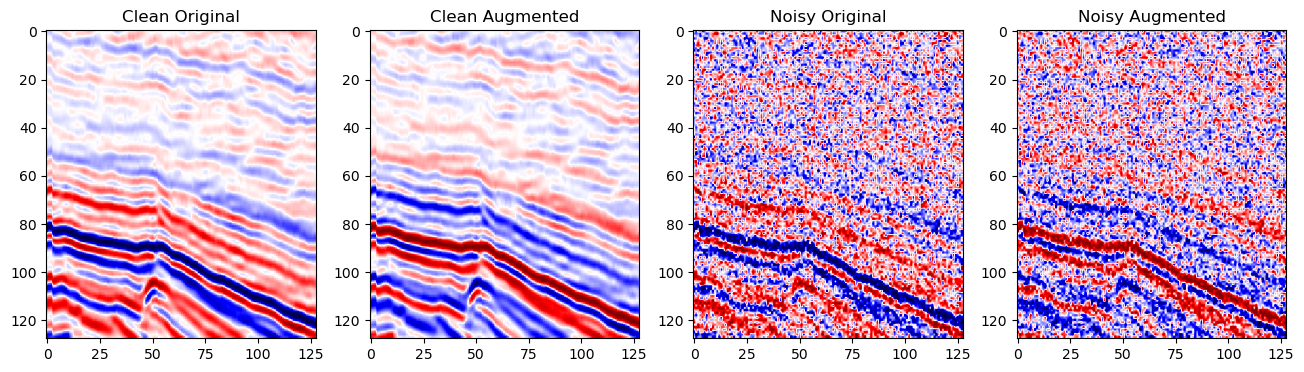

In [107]:
# polarity reversal 



def polarity_reversal(clean_noisy_tuple ,**kwargs) : 
    
    return -1 * clean_noisy_tuple[0] , -1 * clean_noisy_tuple[1]

transforms = A.Compose([
    A.Lambda(name='polarity_reversal', image=polarity_reversal, p=1),
])

aug1 = transforms(image = np.stack([patch_clean, patch_noisy], axis=0))

visualize([patch_clean, patch_noisy], aug1['image'])

## Random Trace Dropout 

clean stats mean : 0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0
noisy stats mean : 0.0060604492145638 , std : 0.2549537368059715 , min : -1.0 , max : 1.0 mean : 0.005691931930955595 , std : 0.390160453795544 , min : -1.0 , max : 1.0


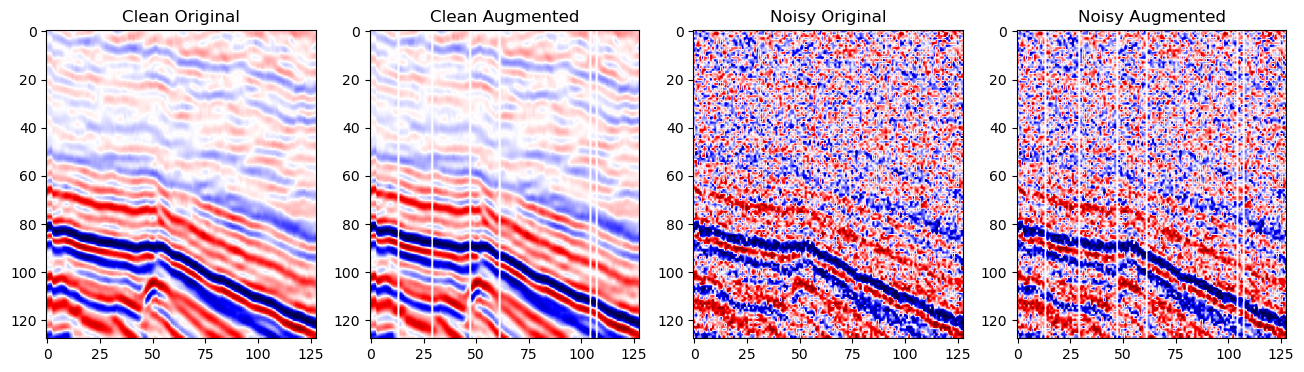

In [108]:
def random_trace_dropout(patch, **kwargs) : # drops one trace
    clean, noisy = patch
    
    pct_dropouts = 0.05
    
    for i in range(int(pct_dropouts * patch.shape[1])) : 
        trace_no = np.random.randint(clean.shape[1])

        clean[: , trace_no] = 0 
        noisy[: , trace_no] = 0 
    
    return clean, noisy

from copy import deepcopy 

transforms = A.Compose([
    A.Lambda(name='random_trace_dropout', image=random_trace_dropout, p=1),
])


aug2 = transforms(image = np.stack([patch_clean, patch_noisy], axis=0))

visualize([patch_clean, patch_noisy], aug2['image'])

## Random High Noise Trace

clean stats mean : 0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0
noisy stats mean : 0.005844249378379107 , std : 0.2670912368163755 , min : -1.0 , max : 1.0 mean : 0.004736514995393256 , std : 0.40322876613246283 , min : -1.0 , max : 1.0


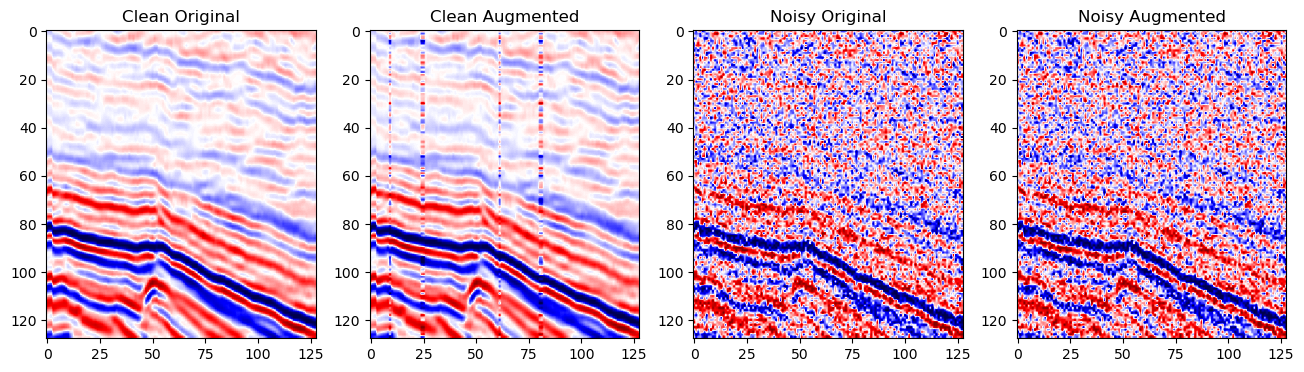

In [109]:
def random_high_noise_trace(patch, **kwargs) : # adds random noise to a few traces
    clean, noisy = patch
    pct_high_noise = 0.05
    
    for i in range(int(pct_high_noise * clean.shape[1])) : 
        trace_no = np.random.randint(patch.shape[1])
        trace_data_clean = clean[:, trace_no]
        trace_data_noisy = noisy[:, trace_no]
        clean[:, trace_no] = add_noise(trace_data_clean, noise_factor=0.1)
        noisy[:, trace_no] = add_noise(trace_data_noisy, noise_factor=0.1)
    
    return clean, noisy


transforms3 = A.Lambda(name='random_high_noise_trace', image=random_high_noise_trace, p=1)


aug2 = transforms3(image = np.stack([patch_clean, patch_noisy], axis=0))

visualize([patch_clean, patch_noisy], aug2['image'])

## Random Amplitude Attenuation

clean stats mean : 0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0
noisy stats mean : 0.0052785409904116485 , std : 0.40052045276070214 , min : -1.0 , max : 1.0 mean : 0.006399641720131526 , std : 0.26129053508866235 , min : -1.0 , max : 1.0


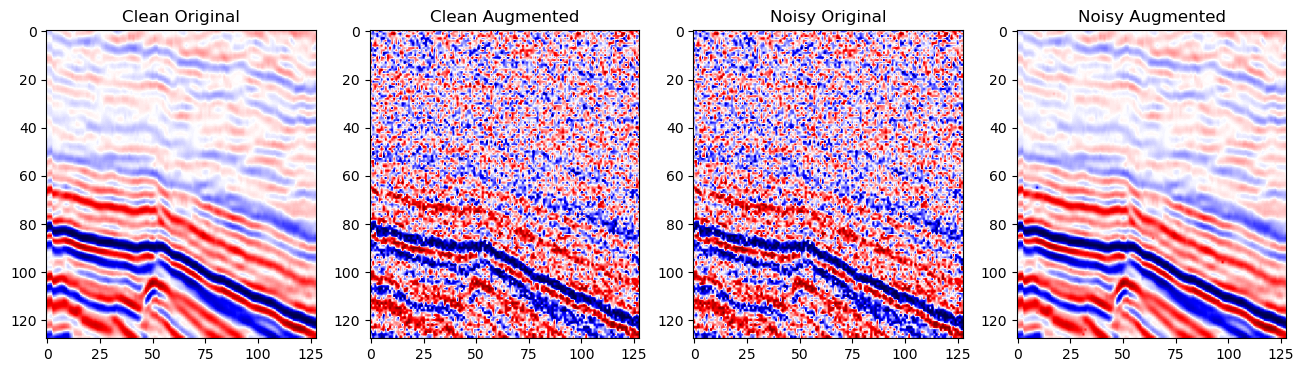

In [110]:
def random_amp_attenuation(patch, **kwargs) : # adds random noise to a few traces
    noisy,clean = patch
    pct_atten = 0.1 # 10 % of points
    amp_scaler = 0.5 # (0, 0.9)
    
    random_inlines = np.random.randint(0,clean.shape[1], int(pct_atten * clean.shape[1]))
    random_twt = np.random.randint(0,clean.shape[0] , int(pct_atten * clean.shape[1]) )
    
    # print(random_inlines, random_twt)
    for twt,iline in zip(random_twt, random_inlines) : 
        clean[twt,iline] =  clean[twt,iline] / amp_scaler
        noisy[twt,iline] =  noisy[twt,iline] / amp_scaler
    
    return clean, noisy

transforms_amp = A.Lambda(name='random_amp_attenuation', image=random_amp_attenuation, p=1)


aug_amp = transforms_amp(image = np.stack([patch_clean, patch_noisy], axis=0))

visualize([patch_clean, patch_noisy], aug_amp['image'])

## Random Trace Shuffle

clean stats mean : 0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0
noisy stats mean : 0.006296043390238232 , std : 0.26116540388077253 , min : -1.0 , max : 1.0 mean : 0.004833448669482328 , std : 0.40105945923123876 , min : -1.0 , max : 1.0


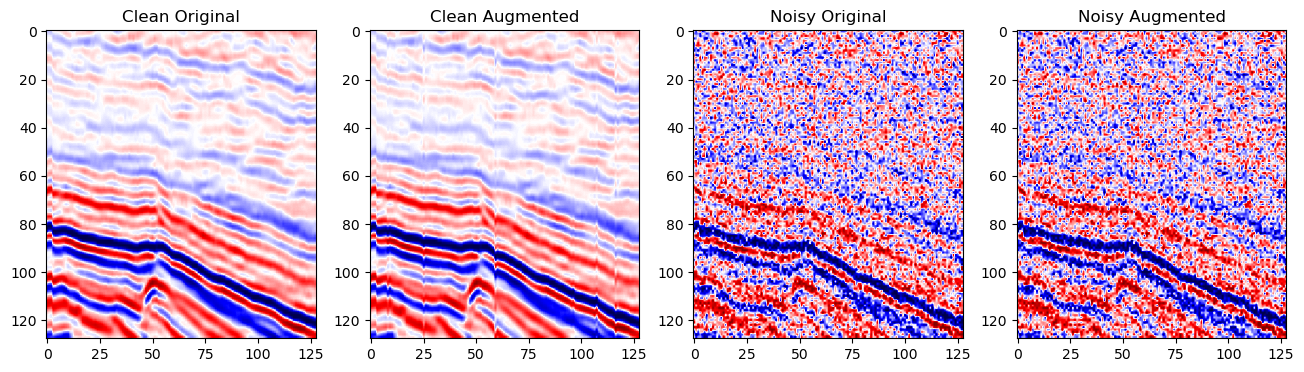

clean stats mean : 0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0
noisy stats mean : 0.0 , std : 0.30618621784789724 , min : -1.0 , max : 1.0 mean : 0.0 , std : 0.30618621784789724 , min : -1.0 , max : 1.0


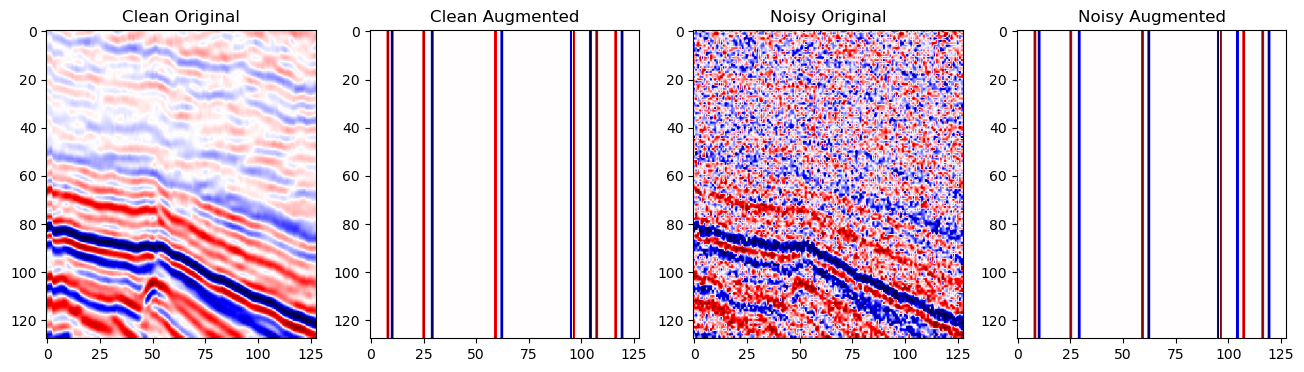

In [111]:
def random_trace_shuffle(patch, **kwargs) : # adds random noise to a few traces
    
    clean, noisy = patch
    pct_atten = 0.05 # 10 % of tracces
    neighborhood = 4
    
    shuffle_mask = np.zeros_like(clean)
    
    def _find_iline(clean, iline_orig, neighborhood) : 
        iline_new = None
        while 1 : 
            iline_new = np.random.randint(-neighborhood,  neighborhood)
            iline_new = iline_orig + iline_new 
            
            if iline_new >= clean.shape[1] : 
                continue 
            else : 
                break 
        return iline_new
    
    random_inlines = np.random.randint(0,patch.shape[1], int(pct_atten * patch.shape[1]))
    
    for iline in random_inlines : 
        shuffle_mask[:, iline] = -1
        
        iline_new = _find_iline(clean, iline, neighborhood)
        
        shuffle_mask[:, iline_new] = 1
        
        new_data = clean[:,iline_new]
        clean[:,iline_new] =  clean[:,iline]
        clean[:,iline] = new_data

        new_data = noisy[:,iline_new]
        noisy[:,iline_new] =  noisy[:,iline]
        noisy[:,iline] = new_data
    
    
    return clean, noisy, shuffle_mask

transforms5 = A.Lambda(name='random_trace_shuffle', image=random_trace_shuffle, p=1)


aug5 = transforms5(image = np.stack([patch_clean, patch_noisy], axis=0))

visualize([patch_clean, patch_noisy], aug5['image'][:-1])
visualize([patch_clean, patch_noisy], [aug5['image'][-1], aug5['image'][-1]])

## Horizontal Flip

clean stats mean : 0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0
noisy stats mean : 0.006321991096359225 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.0052303604895156865 , std : 0.40037187119835815 , min : -1.0 , max : 1.0


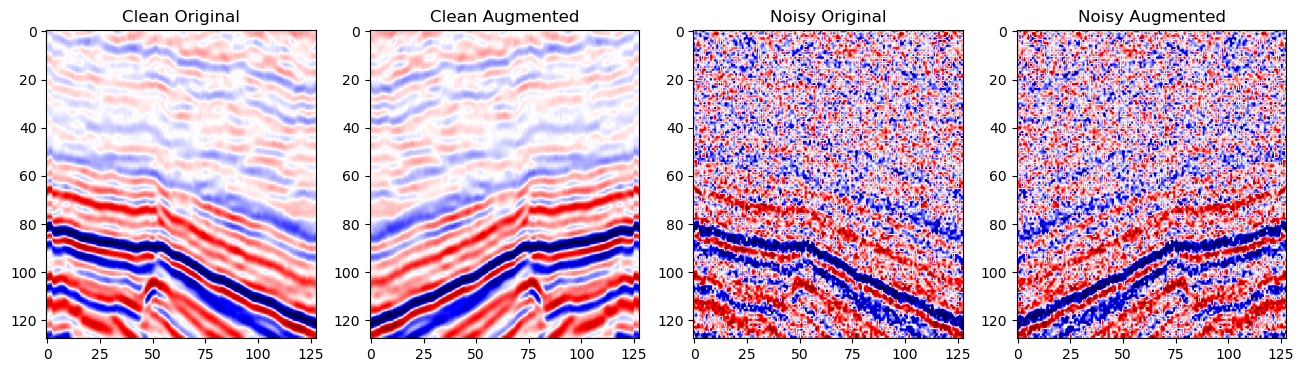

In [112]:
# polarity reversal 
def horizontal_flip(patch ,**kwargs) : 
    clean, noisy = patch
    return np.flip(clean, axis=-1), np.flip(noisy, axis=-1)

transforms_hp = A.Compose([
    A.Lambda(name='horizontal_flip', image=horizontal_flip, p=1),
])

aug_hp = transforms_hp(image = np.stack([patch_clean, patch_noisy], axis=0))

visualize([patch_clean, patch_noisy], aug_hp['image'])

## Random Amplitude Shift


clean stats mean : 0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0
noisy stats mean : 0.006548837029145059 , std : 0.2627687574196669 , min : -1.0 , max : 1.0 mean : 0.005398136473211008 , std : 0.40126867589569826 , min : -1.0 , max : 1.0


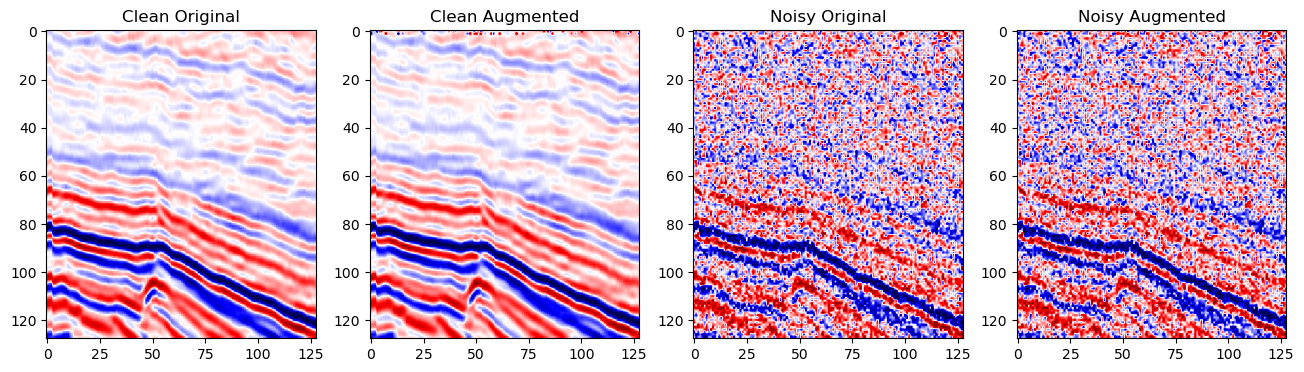

In [113]:
def random_amp_shift(patch, **kwargs) : # adds random noise to a few traces
    clean, noisy = patch
    pct_atten = 0.5 # 10 % of points
    
    mask = np.zeros_like(patch)
    
    random_inlines = np.random.randint(0,patch.shape[1], int(pct_atten * patch.shape[1]))
    random_twt = np.random.randint(0,patch.shape[0] , int(pct_atten * patch.shape[1]) )
    
    # print(random_inlines, random_twt)
    for twt,iline in zip(random_twt, random_inlines) : 
        
        mask[twt,iline] = 1
        
        rand_amp_shift = np.random.choice([-1,1]) * 0.1 * np.random.randint(0,9)
        
        clean[twt,iline] =  np.clip(clean[twt,iline] + rand_amp_shift , -0.9, 0.9 )
        noisy[twt,iline] =  np.clip(noisy[twt,iline] + rand_amp_shift , -0.9, 0.9 )
    
    return clean, noisy

transforms7 = A.Lambda(name='random_amp_shift', image=random_amp_shift, p=1)


aug7 = transforms7(image = np.stack([patch_clean, patch_noisy], axis=0))

visualize([patch_clean, patch_noisy], aug7['image'])

clean stats mean : 0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0
noisy stats mean : 0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0


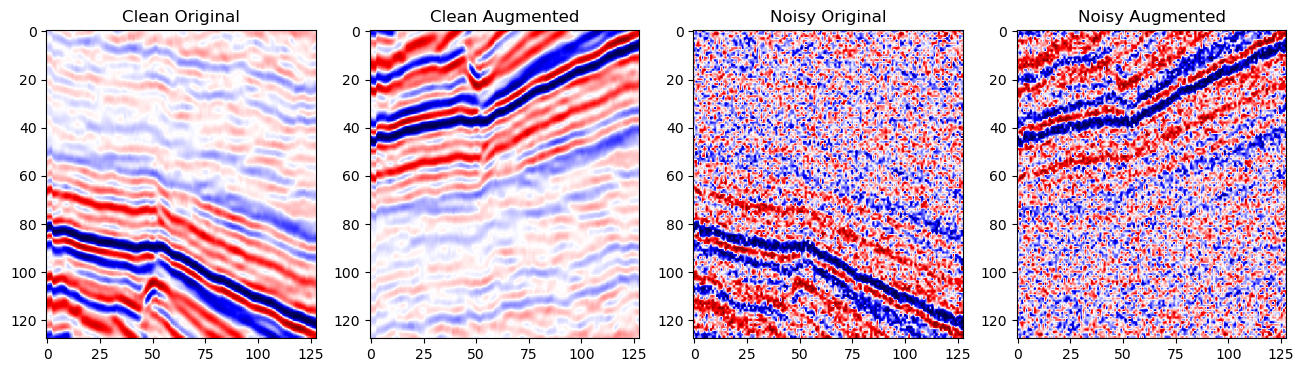

In [114]:

## Vertical flip
def vertical_flip(patch ,**kwargs) :
    clean, noisy = patch
    return np.flip(clean, axis=0), np.flip(noisy, axis=0)

transforms8 = A.Compose([
    A.Lambda(name='vertical_flip', image=vertical_flip, p=1),
])

aug8 = transforms8(image = np.stack([patch_clean, patch_noisy], axis=0))

visualize([patch_clean, patch_noisy], aug8['image'])

Vertical Flip does not apply since , as depth increases, the amplitude of the reflections decreases. 

## Rotate

clean stats mean : 0.0063219910963592234 , std : 0.2611432640448125 , min : -1.0 , max : 1.0 mean : 0.005230360489515688 , std : 0.40037187119835815 , min : -1.0 , max : 1.0
noisy stats mean : 0.004846338001536977 , std : 0.25450424590951726 , min : -1.0 , max : 0.9993849368390703 mean : 0.004414678173795882 , std : 0.3600318357510855 , min : -1.0 , max : 1.0


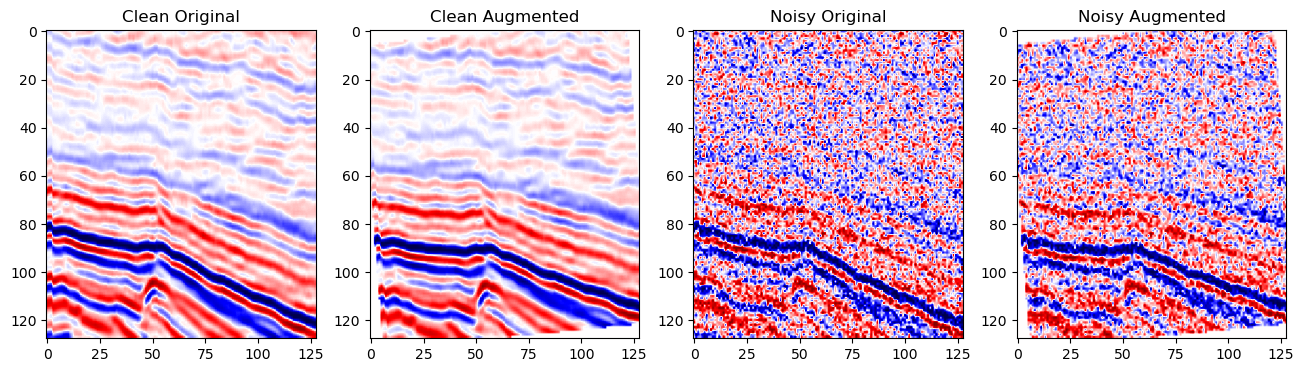

In [115]:
from scipy.ndimage import rotate


def rotate_patch(patch, **kwargs) : 
    clean, noisy = patch
    rot_angle = np.random.choice([-10,-5,-2.5, 2.5,5,10])

    rotated_clean = rotate(clean, angle = rot_angle , reshape=False )
    rotated_noisy = rotate(noisy, angle = rot_angle , reshape=False )
    # return np.clip(clipped_zoom(rotated, 1.2),-1,1)
    return np.clip(rotated_clean, -1,1) , np.clip(rotated_noisy, -1,1)


transforms8 = A.Compose([
    A.Lambda(name='rotate_patch', image=rotate_patch, p=1),
])

aug8 = transforms8(image = np.stack([patch_clean, patch_noisy], axis=0))

visualize([patch_clean, patch_noisy], aug8['image'])

In [116]:
# zoom helper 
from scipy.ndimage import zoom

def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

## Debugging Faciesmark Datamodule Augmentation
NOTE : A.Compose is not working with multiple A.Lambda, hence they are split into multiple transform sets

In [117]:
patch_noisy.shape

(128, 128)

In [118]:
patch_clean.shape

(128, 128)

In [119]:
patch_pair = np.stack([patch_clean, patch_noisy], axis=0) 
patch_pair.shape

(2, 128, 128)

In [120]:
import albumentations as A
import sys 
sys.path.append('../utils')

from augmentations import polarity_reversal, random_trace_dropout, random_high_noise_trace, random_amp_attenuation, random_trace_shuffle, horizontal_flip, random_amp_shift, rotate_patch

In [121]:
tset_1 = A.Lambda(name='polarity_reversal', image=polarity_reversal, p=1 )
tset_2 =  A.OneOf([
                    A.Lambda(name='horizontal_flip', image = horizontal_flip, p = 1),
                   A.Lambda(name='rotate_patch', image = rotate_patch, p = 1),
                 ])
tset_3 =  A.OneOf([
                    A.Lambda(name='random_trace_dropout', image = random_trace_dropout, p = 1),
                    A.Lambda(name='random_high_noise_trace', image = random_high_noise_trace, p = 1),
                    A.Lambda(name='random_trace_shuffle', image = random_trace_shuffle, p = 1),
                ])

tset_4 = A.OneOf([
                    A.Lambda(name='random_amp_attenuation', image = random_amp_attenuation , p = 1), 
                    A.Lambda(name='random_amp_shift', image = random_amp_shift , p = 1), 
                ])


aug_1 = tset_1(image=np.stack([patch_clean, patch_noisy], axis=0) )['image'] 
aug_2 = tset_2(image = np.stack(aug_1, axis=0))['image']
aug_3 = tset_3(image = np.stack(aug_2, axis=0))['image']
aug_4 = tset_4(image = np.stack(aug_3, axis=0))['image']

aug_4[0].shape, aug_4[1].shape


((128, 128), (128, 128))